In [11]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Revisiting period doubling and the route to chaos

In an earlier notebook, we analyzed the logistic map, a deterministic discrete-time dynamical system:

$$x_{n+1} = f(x_n) = r x_n (1 - x_n)$$

where $x_n$ is the population at time $n$ and $r$ is a parameter that controls the growth rate of the population in each generation. Recall that, as $r$ increases, the system undergoes a series of bifurcations, from a stable fixed point to a period-2 cycle to a period-4 cycle, period-8, and so on, until it reaches a critical value of $r$ at which the system becomes chaotic.

This mechanism is observed in many other physical systems, including, famously, in the velocity fluctuations of a rotating fluid flow as the rotation speed is increased. The flow fluctuations gradually double in frequency, then double again, and so on, until the flow becomes fully turbulent.

*This notebook was partly adapted from [Jake VanderPlas's excellent FFT tutorial](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)*

### What does the period doubling look like in the frequency domain?**

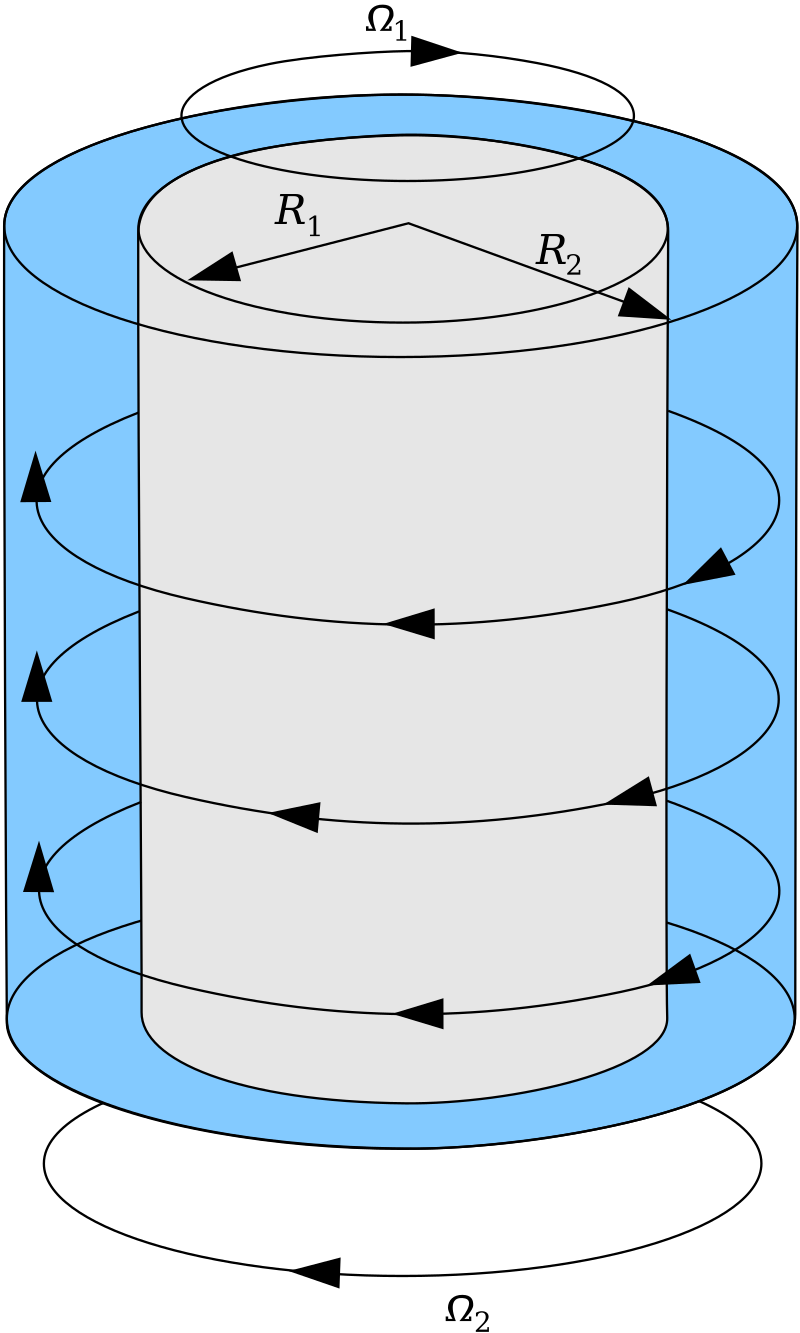

In [7]:
Image(filename='../resources/CouetteTaylorSystem.png', width=300)
# https://en.wikipedia.org/wiki/Taylor%E2%80%93Couette_flow#/media/File:CouetteTaylorSystem.svg

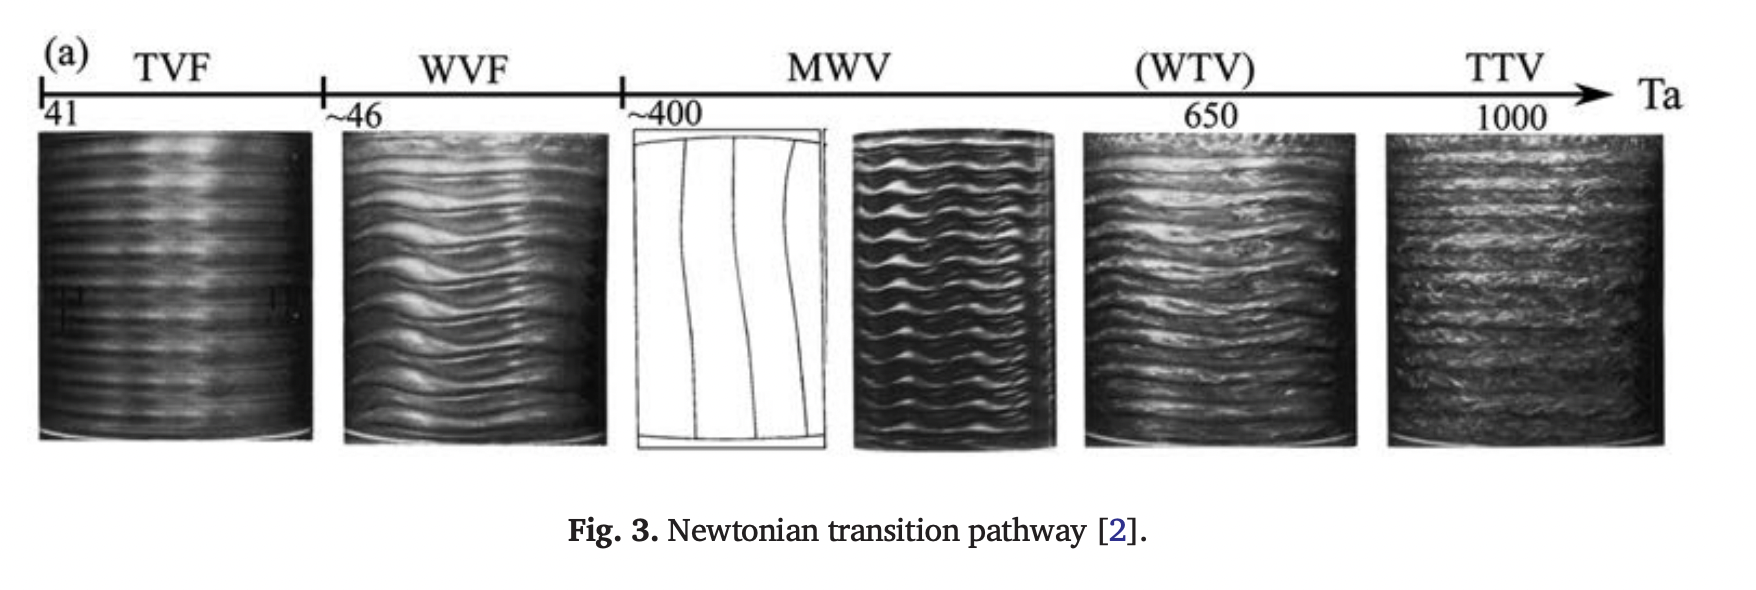

In [8]:
Image(filename='../resources/doubling.png', width=700)
# https://www.sciencetalks-journal.com/article/S2772-5693%2822%2900115-3/pdf

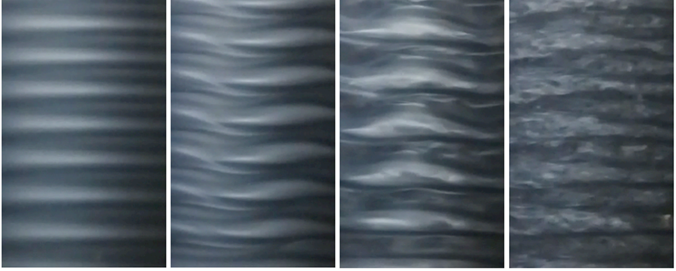

In [9]:
Image(filename='../resources/WillametteTaylorCouetteRot2.png')
# https://advlabs.aapt.org/wiki/Taylor-Couette_Flow

## Period doubling in continuous time

Rather than simulating a full turbulent flow, we will simulate a continuous-time deterministic dynamical system that exhibits period-doubling bifurcations leading to chaos. This three-dimensional system is much simpler than an infinite-dimensional simulation of the Navier-Stokes equations, but it still exhibits the same qualitative behavior.

Text(0, 0.5, 'y')

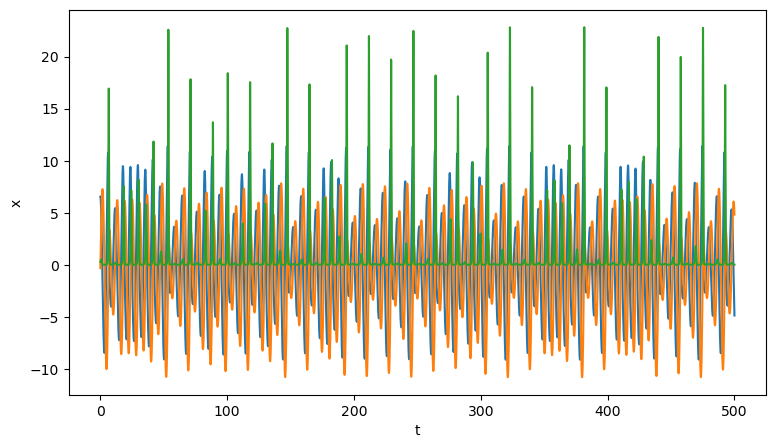

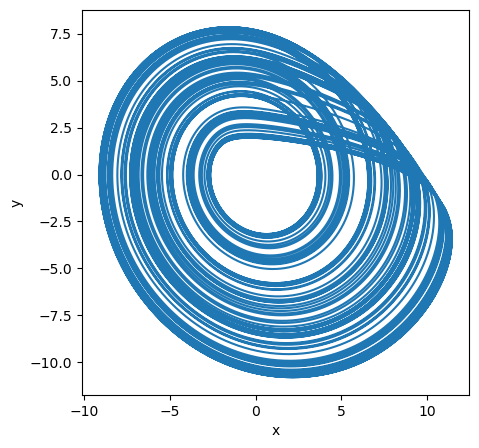

In [12]:
# solve_ivp
from scipy.integrate import solve_ivp

class Rossler:
    """
    A continuous-time dynamical system that exhibits some properties associated with 
    velocity fluctuations in turbulent fluid flow. The parameter c can b thought of as
    increasing the rotary driving force on the sequence.

    This system exhibits period doubling in continuous time
    """

    def __init__(self, a=0.2, b=0.2, c=5.7):
        self.a = a
        self.b = b
        self.c = c

    def rhs(self, t, x):
        return np.array([-x[1] - x[2],
                         x[0] + self.a * x[1],
                         self.b + x[2] * (x[0] - self.c)])
    
    def solve(self, t_span, x0, **kwargs):
        return solve_ivp(self.rhs, t_span, x0, method="Radau", **kwargs)
    
ic = np.array([6.55, -0.317,  0.284])
t_span = [0, 500]
model = Rossler()

sol = model.solve(t_span, ic, max_step=0.01)
# discard a transient

plt.figure(figsize=(9, 5))
plt.plot(sol.t, sol.y.T)
plt.xlabel('t')
plt.ylabel('x')

plt.figure(figsize=(5, 5))
plt.plot(sol.y[0], sol.y[1])
plt.xlabel('x')
plt.ylabel('y')



We will vary the value of a parameter $c$ in the system in order to observe period doubling leading to full chaos, which is turbulence.

Text(0.5, 1.0, 'c = 5.7')

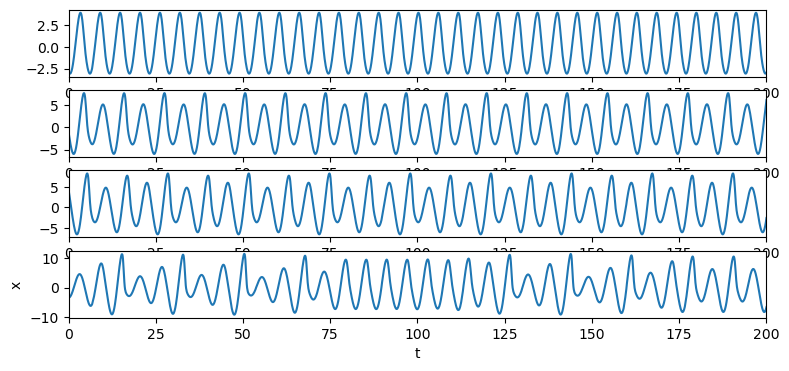

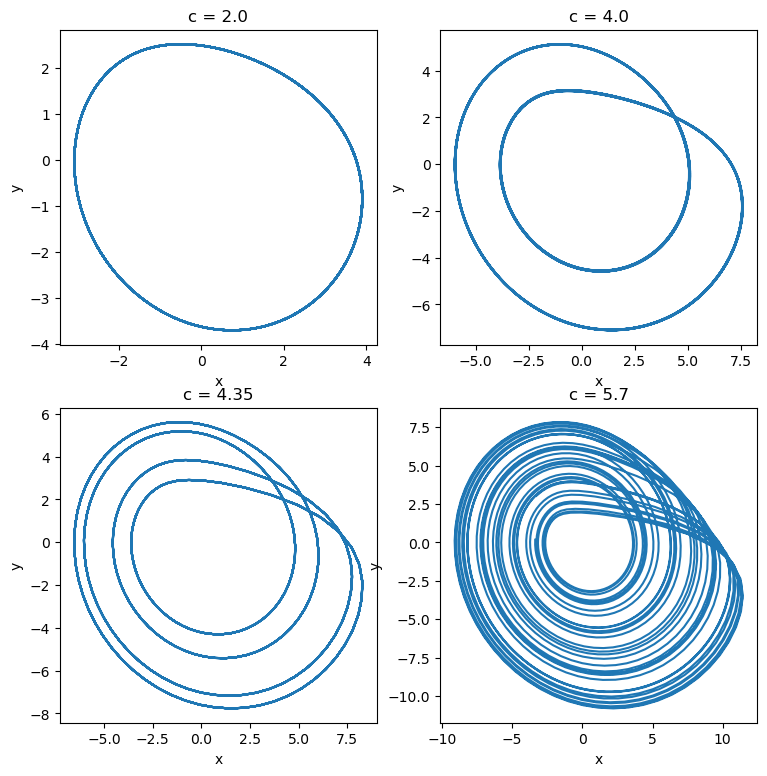

In [13]:
ic = np.array([6.55, -0.317,  0.284])
t_span = [0, 500]


model = Rossler()
model.c = 2.0
sol = model.solve(t_span, ic, max_step=0.1)
y2 = sol.y.T[-2048:]

model.c = 3.8
sol = model.solve(t_span, ic, max_step=0.1)
y4 = sol.y.T[-2048:]

model.c = 4.1
sol = model.solve(t_span, ic, max_step=0.1)
y8 = sol.y.T[-2048:]

model.c = 5.7
sol = model.solve(t_span, ic, max_step=0.1)
yc = sol.y.T[-2048:]

t = sol.t[:2048]

plt.figure(figsize=(9, 4))
plt.subplot(4, 1, 1)
plt.plot(t, y2[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 2)
plt.plot(t, y4[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 3)
plt.plot(t, y8[:, 0])
plt.xlim(0, 200)
plt.subplot(4, 1, 4)
plt.plot(t, yc[:, 0])
plt.xlim(0, 200)
plt.xlabel('t')
plt.ylabel('x')


plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.plot(y2[:, 0], y2[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 2.0')

plt.subplot(2, 2, 2)
plt.plot(y4[:, 0], y4[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 4.0')

plt.subplot(2, 2, 3)
plt.plot(y8[:, 0], y8[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 4.35')

plt.subplot(2, 2, 4)
plt.plot(yc[:, 0], yc[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('c = 5.7')

# plt.figure(figsize=(9, 5))
# plt.plot(sol.t, sol.y.T)
# plt.xlabel('t')
# plt.ylabel('x')

# The discrete Fourier Transform

Suppose that we want to analyze a signal $x(t)$ that is a function of time. We can think of this signal as a sum of sinusoids of different frequencies, amplitudes, and phases:

$$
x(t) = \sum_{k=0}^{\infty} A_k \sin(2\pi f_k t + \phi_k)
$$

where $A_k$ is the amplitude of the $k$th sinusoid, $f_k$ is its frequency, and $\phi_k$ is its phase. The discrete Fourier transform (DFT) is an algorithm that allows us to compute the amplitudes, frequencies, and phases of the sinusoids that make up a signal. It is an information-preserving integral transformation that maps a signal from the time domain to the frequency domain.

The power spectrum of a signal is the square of the amplitudes of the sinusoids that make up the signal. We can think of it as a histogram showing the relative amount of power in each frequency bin.



/Users/william/miniconda3/envs/cphy/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


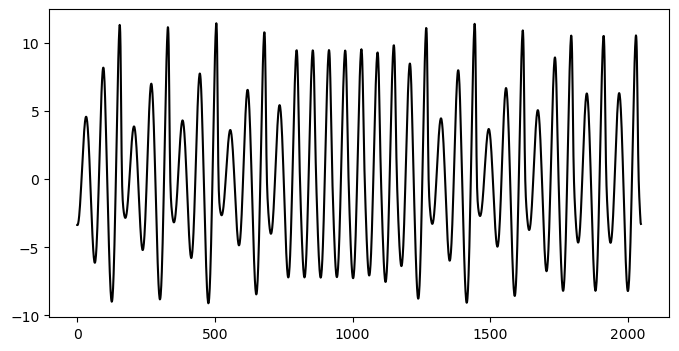

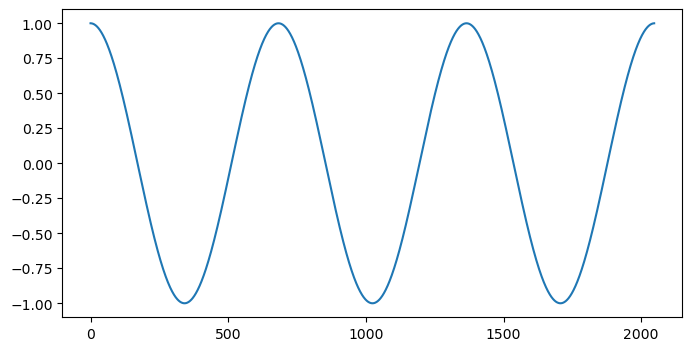

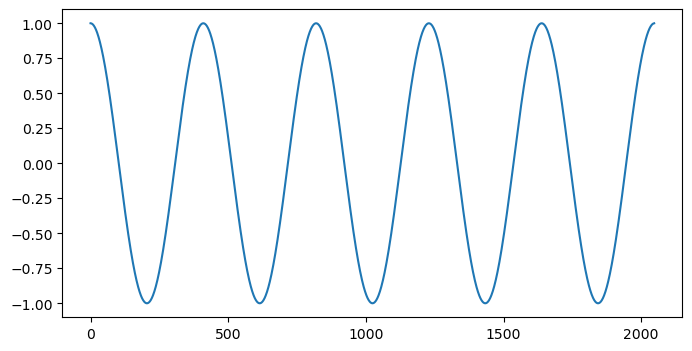

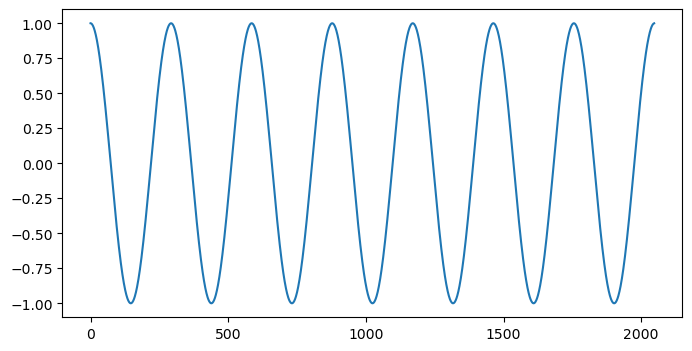

In [14]:
time_seriesc = yc[:, 0]
time_series2 = y2[:, 0]
time_series4 = y4[:, 0]
time_series8 = y8[:, 0]

plt.figure(figsize=(8, 4))
plt.plot(time_seriesc, 'k')

n = len(time_seriesc)
basis_functions = np.exp(-2j * np.pi * np.arange(n)[:, None] * np.arange(n) / n)

plt.figure(figsize=(8, 4))
plt.plot(basis_functions[3])
plt.figure(figsize=(8, 4))
plt.plot(basis_functions[5])
plt.figure(figsize=(8, 4))
plt.plot(basis_functions[7])

## Implementing the discrete Fourier transform

A discrete approach to this algorithm involves projecting our signal onto a set of "pure" basis functions corresponding to single-frequency (monochromatic) signals. In continuous time, we would have a continuous and uncountable set of frequencies, but for a discrete signal we have a finite number of possible frequency bins spanning $1/N$ to $T/N$, where $T$ is the total time of the signal and $N$ is the number of timepoints.

If our observed signal is $x_n = x_1, x_2, ..., x_N$, then the discrete Fourier transform becomes
$$
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N}
$$
with corresponding inverse transform
$$
x_n = \frac{1}{N}\sum_{k=0}^{N-1} X_k e^{i~2\pi~k~n~/~N}
$$
In our naive implementation below, we compute the set of "pure" functions, and then project the signal onto this basis. This approach is easy to vectorize, since all operations that touch all $N$ elements of the signal can be written as dot products.

In matrix notation, the vectorized DFT is given by
$$
\mathbf{X} = M \cdot \mathbf{x}
$$
where
$$
M_{kn} = e^{-i~2\pi~k~n~/~N}.
$$

Text(0.5, 0, 'Frequency')

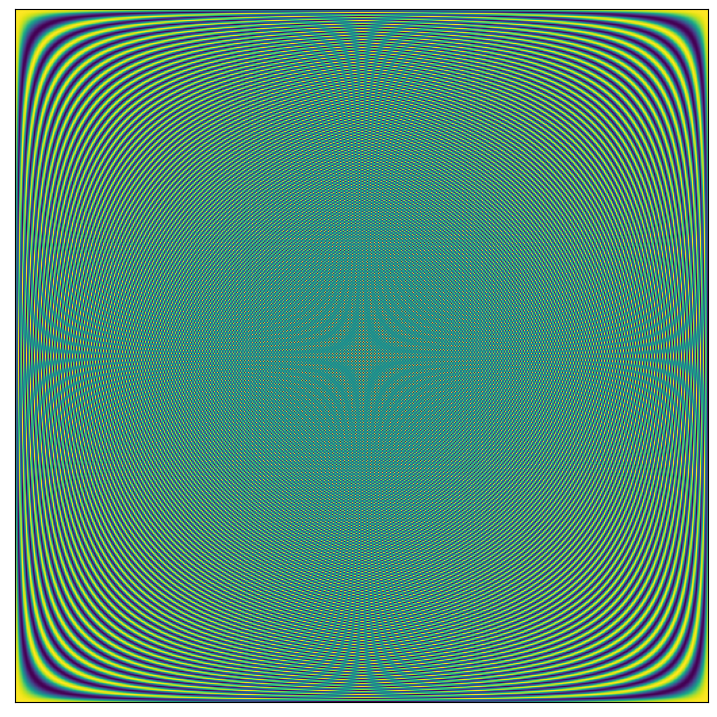

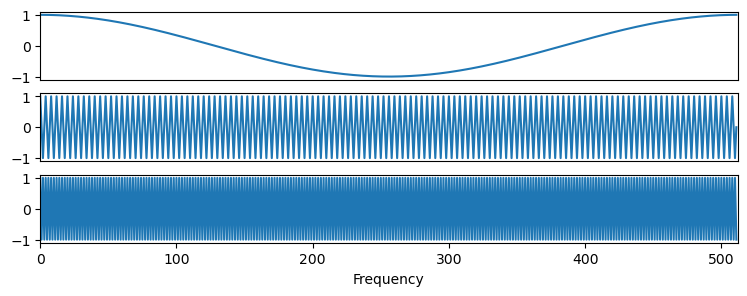

In [17]:
# What does the M matrix look like?

# Python has built-in complex numbers, which numpy supports
N = 512
coeffs = np.exp(-2j * np.pi * np.arange(N)[:, None] * np.arange(N) / N)

plt.figure(figsize=(9, 9))
plt.imshow(np.real(coeffs), cmap='viridis')
plt.xticks([]); plt.yticks([])

plt.figure(figsize=(9, 3))
# 3 subplots stacked vertically
plt.subplot(3, 1, 1)
plt.plot(np.real(coeffs)[:, 1])
# plt.title("Second Row")
plt.xlim(0, 512); plt.xticks([])

plt.subplot(3, 1, 2)
plt.plot(np.real(coeffs)[:, 128])
# plt.title("Seventh Row")
plt.xlim(0, 512); plt.xticks([])

plt.subplot(3, 1, 3)
plt.plot(np.real(coeffs)[:, 256])
# plt.title("Highest Frequency Row")
plt.xlim(0, 512)
plt.xlabel("Frequency")




Let's now implement the DFT in Python. We will use the built-in `numpy.fft.fft` function to check our results.

In [18]:
class SignalTransform:
    """
    A base class for signal transformations

    Parameters:
        center (bool): whether to center the signal before transforming
    """
    
    def __init__(self, center=True):
        self.center = center
        
    def preprocess(self, signal):
        if self.center:
            signal -= np.mean(signal, axis=0, keepdims=True)
    
    # static methods don't require a "self" argument, but also can't 
    # access instance attributes. For example, this function can't see the 
    # self.center variable that we set in the __init__() constructor 
    @staticmethod
    def freq_bounds(signal):
        """Compute upper and lower frequency bounds using the Nyquist criterion"""
        n = len(signal)
        return 1 / (2 * n), n / 2


class DiscreteFourierTransform(SignalTransform):
    """
    An iterative implementation of the discrete Fourier transform

    Vectorized using array broadcasting
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def transform(self, signal):
        """Compute the discrete Fourier transform of a signal"""

        self.preprocess(signal)
        
        n = len(signal)
        k_vals = np.arange(n)[:, None]
        
        # Python has built-in complex numbers, which numpy supports
        coeffs = np.exp(-2j * np.pi * k_vals * np.arange(n) / n)
        
        return np.dot(coeffs, signal)

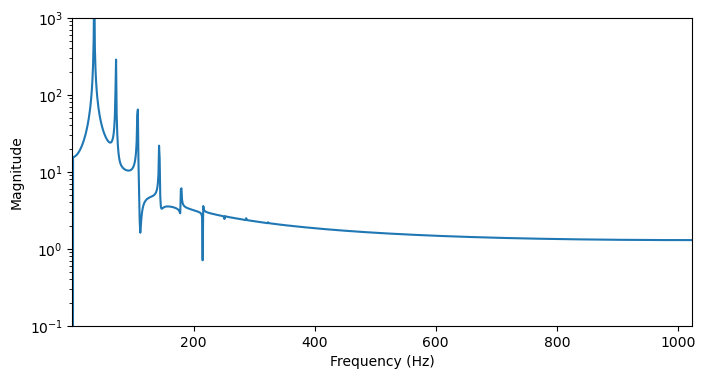

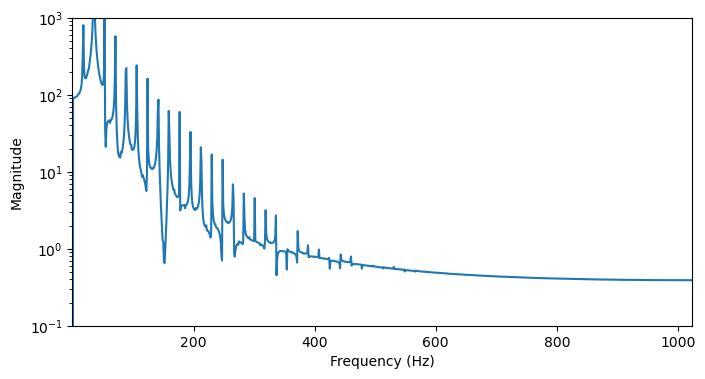

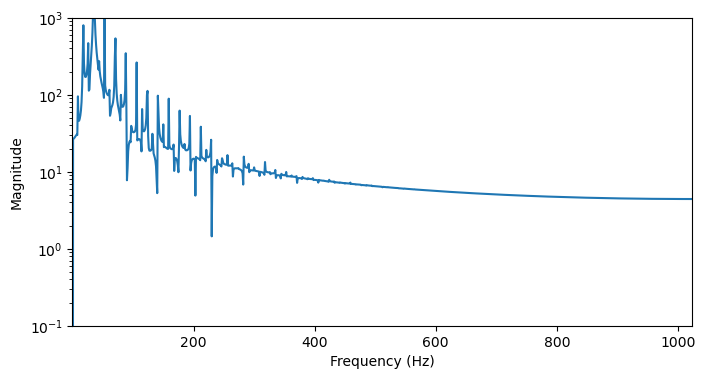

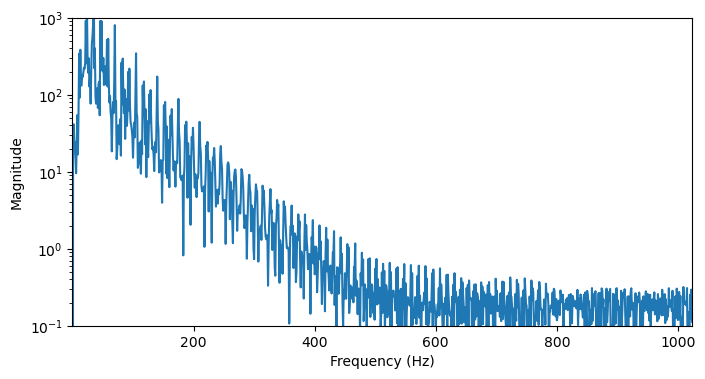

In [19]:
## Test that it works

for ts in [time_series2, time_series4, time_series8, time_seriesc]:
    dft = DiscreteFourierTransform()
    coeffs = dft.transform(ts)

    plt.figure(figsize=(8, 4))
    plt.semilogy(np.abs(coeffs))
    plt.xlim([dft.freq_bounds(ts)[0], dft.freq_bounds(ts)[1]])
    plt.ylim([1e-1, 1e3])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')


## Questions

+ Notice that our base class includes a `freq_bounds` function. Where do these bounds come from?

+ If our signal contains $N$ timepoints, what do you expect to be the runtime of the our naive DFT implementation?


### A symmetry in the discrete equations

Notice that our DFT calculation has an even-odd symmetry. If we shift our Fourier transform calculation above in order to find $X_{N+k}$, the calculation becomes
$$
\begin{align*}
X_{N + k} &=  \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~(N + k)~n~/~N} \\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{- i~2\pi~n} \cdot e^{-i~2\pi~k~n~/~N} \\
          &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
          &= X_k
\end{align*}
$$
because $\exp[2\pi~i~n] = 1$ for all $n$. Using this property, we can derive the following symmetry
$$
X_{k + i \cdot N} = X_k
$$

We can now see that it's possible to divide our Fourier transform calculation into two parts by splitting the index $n$ into even and odd parts:
$$
\begin{align*}
X_k &= \sum_{n=0}^{N-1} x_n \cdot e^{-i~2\pi~k~n~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~(2m)~/~N} + \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~(2m + 1)~/~N} \\
    &= \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} + e^{-i~2\pi~k~/~N} \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
\end{align*}
$$

Since our argument does not depend on the specific value of $n$, we now have a clear way to attack this problem: 

1. Given a full signal on which to compute the FFT, split the signal into two smaller signals by decimating the original signal by a factor of 2:

$$
x_{\rm even} = x_0, x_2, x_4, ..., x_{N-2} \\
x_{\rm odd} = x_1, x_3, x_5, ..., x_{N-1}
$$

2. Compute the FFT of each of the two smaller signals.

$$
X_{\rm even} = \sum_{m=0}^{N/2 - 1} x_{2m} \cdot e^{-i~2\pi~k~m~/~(N/2)} \\
X_{\rm odd} = \sum_{m=0}^{N/2 - 1} x_{2m + 1} \cdot e^{-i~2\pi~k~m~/~(N/2)}
$$

3. Combine the two FFTs into a single FFT of the full signal.

$$
X_k = X_{\rm even} + e^{-i~2\pi~k~/~N} X_{\rm odd}
$$

Let's verify that this works using our DFT implementation above.



Text(0, 0.5, 'Magnitude')

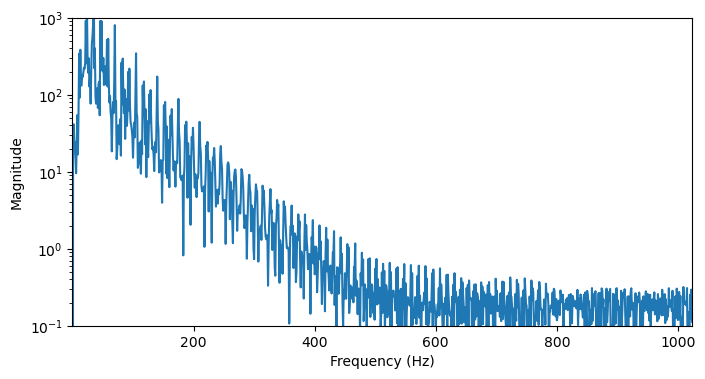

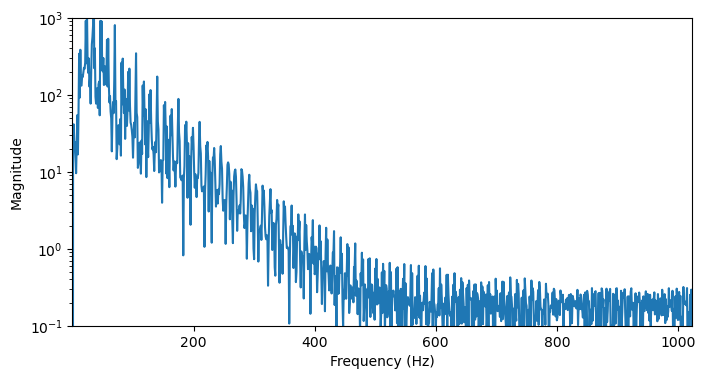

In [20]:
dft = DiscreteFourierTransform()
coeffs = dft.transform(time_seriesc)
dft_vals = np.abs(coeffs)

plt.figure(figsize=(8, 4))
plt.semilogy(dft_vals)
plt.xlim([dft.freq_bounds(time_seriesc)[0], dft.freq_bounds(time_seriesc)[1]])
plt.ylim([1e-1, 1e3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

time_series_even = time_seriesc[::2]
time_series_odd = time_seriesc[1::2]
coeffs_even = dft.transform(time_series_even)
coeffs_odd = dft.transform(time_series_odd)

# combine into the full DFT
coeffs_overall = np.zeros_like(coeffs) # set aside array of length N

# can express the regular sum as a sum over the even and odd terms
coeffs_overall[:len(coeffs) // 2] = coeffs_even + np.exp(-2j * np.pi * np.arange(len(coeffs) // 2) / len(coeffs)) * coeffs_odd
coeffs_overall[len(coeffs) // 2:] = coeffs_even - np.exp(-2j * np.pi * np.arange(len(coeffs) // 2) / len(coeffs)) * coeffs_odd



plt.figure(figsize=(8, 4))
plt.semilogy(np.abs(coeffs_overall))
plt.xlim([dft.freq_bounds(time_seriesc)[0], dft.freq_bounds(time_seriesc)[1]])
plt.ylim([1e-1, 1e3])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')



## The Fast Fourier Transform

Why stop at just one split? We can continue to split the signal into smaller and smaller subarrays, yielding the following algorithm:

1. Given a full signal on which to compute the FFT, split the signal into two smaller signals by decimating the original signal by a factor of 2.

2. If the length of the two subarrays is greater than 2, then split each of the two subarrays into two smaller subarrays,

3. Proceed recursively until the length of the subarrays is 1, at which point the DFT is trivial to compute.

$$
FFT(x) = \begin{cases}
x & \text{if } N = 1 \\
\begin{bmatrix}
FFT(x_{\rm even}) + e^{-i~2\pi~k~/~N} FFT(x_{\rm odd}) \\
FFT(x_{\rm even}) - e^{-i~2\pi~k~/~N} FFT(x_{\rm odd})
\end{bmatrix} & \text{if } N > 1
\end{cases}
$$

4. Now combine the DFTs of the two single-element subarrays using our results from above

$$
X_k = X_{\rm even} + e^{-i~2\pi~k~/~N} X_{\rm odd}
$$

This will double the length of the subarray, so we now have a subarray of length 2.

5. Now repeat Step 4 until we have the full DFT of the original signal.







In [ ]:
Image("../resources/fft.png", width=700)
# Source: https://riptutorial.com/algorithm/example/27088/radix-2-fft

## Recursion

The FFT is naturally suited to recursion, with the short length-1 and length-2 signal cases representing *base cases* for returns. This approach is known as divide-and-conquer.

We will define a function `fft` that takes a signal and returns its DFT. The function will split the signal and then call itself, until it hits a "Base Case" where the signal is length 1 or 2. At this point, it will return the trivial DFT of the signal. The function will then combine the DFTs of the two subarrays and return the full DFT of the original signal.

In [3]:

class FastFourierTransform(SignalTransform):
    """
    A recursive implementation of the fast Fourier transform
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def transform(self, signal):
        
        n = len(signal)
        
        if n == 1:  # base case; stop recursion when an array of length 1 is reached
            return signal
        else:
            ## Decimate the signal by 2
            signal_even = self.transform(signal[::2])
            signal_odd = self.transform(signal[1::2])
            coeffs = np.exp(-2j * np.pi * np.arange(n) / n)
            signal_new =  np.hstack([
                signal_even + coeffs[:(n // 2)] * signal_odd,
                signal_even + coeffs[(n // 2):] * signal_odd
            ])
            return signal_new


## Runtime complexity of the FFT
While the vanilla DFT has runtime complexity $N^2$ due to the need to compute $N$ dot products for each of the $N$ pure frequency components, the FFT has runtime $N \log N$ because it reduces the problem in each step


In [4]:
x = np.random.random(2**9) # Needs to be a power of 2

dft_m = DiscreteFourierTransform()
%timeit dft_m.transform(x) 
# check that it matches numpy's implementation
print(np.allclose(dft_m.transform(x), np.fft.fft(x)))

fft_m = FastFourierTransform()
%timeit fft_m.transform(x) 
# check that it matches numpy's implementation
print(np.allclose(fft_m.transform(x), np.fft.fft(x)))

4.41 ms ± 33.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
2.83 ms ± 18.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


Text(0, 0.5, 'Time (s)')

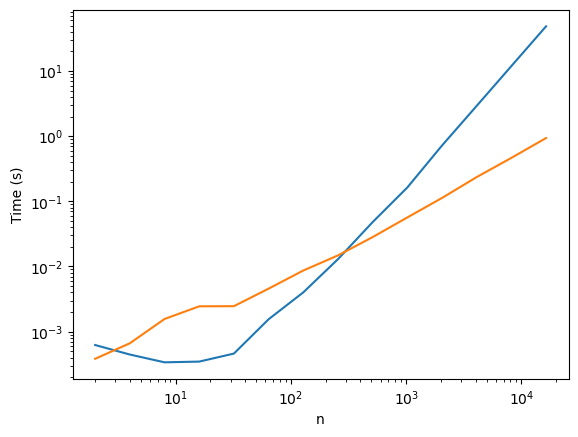

In [5]:
import timeit

n_vals = 2**np.arange(1, 15)

x = np.random.random(int(n_vals[-1])) # Needs to be a power of 2
dft_m = DiscreteFourierTransform()
fft_m = FastFourierTransform()

all_times = []
for n in n_vals:
    time1 = timeit.timeit("dft_m.transform(x[:n])", globals=globals(), number=10)
    time2 = timeit.timeit("fft_m.transform(x[:n])", globals=globals(), number=10)
    all_times.append([time1, time2])
all_times = np.array(all_times)

plt.figure()
plt.loglog(n_vals, all_times[:, 0])
plt.loglog(n_vals, all_times[:, 1])
plt.xlabel('n')
plt.ylabel('Time (s)')

### Continuous spectrum dynamical systems

Another term for chaotic systems is continuous-spectrum systems. This is because the power spectrum of a chaotic system is continuous, meaning that oscillations appear at a continuum of frequencies. These can be thought of as interacting modes, or excitations, of the system.

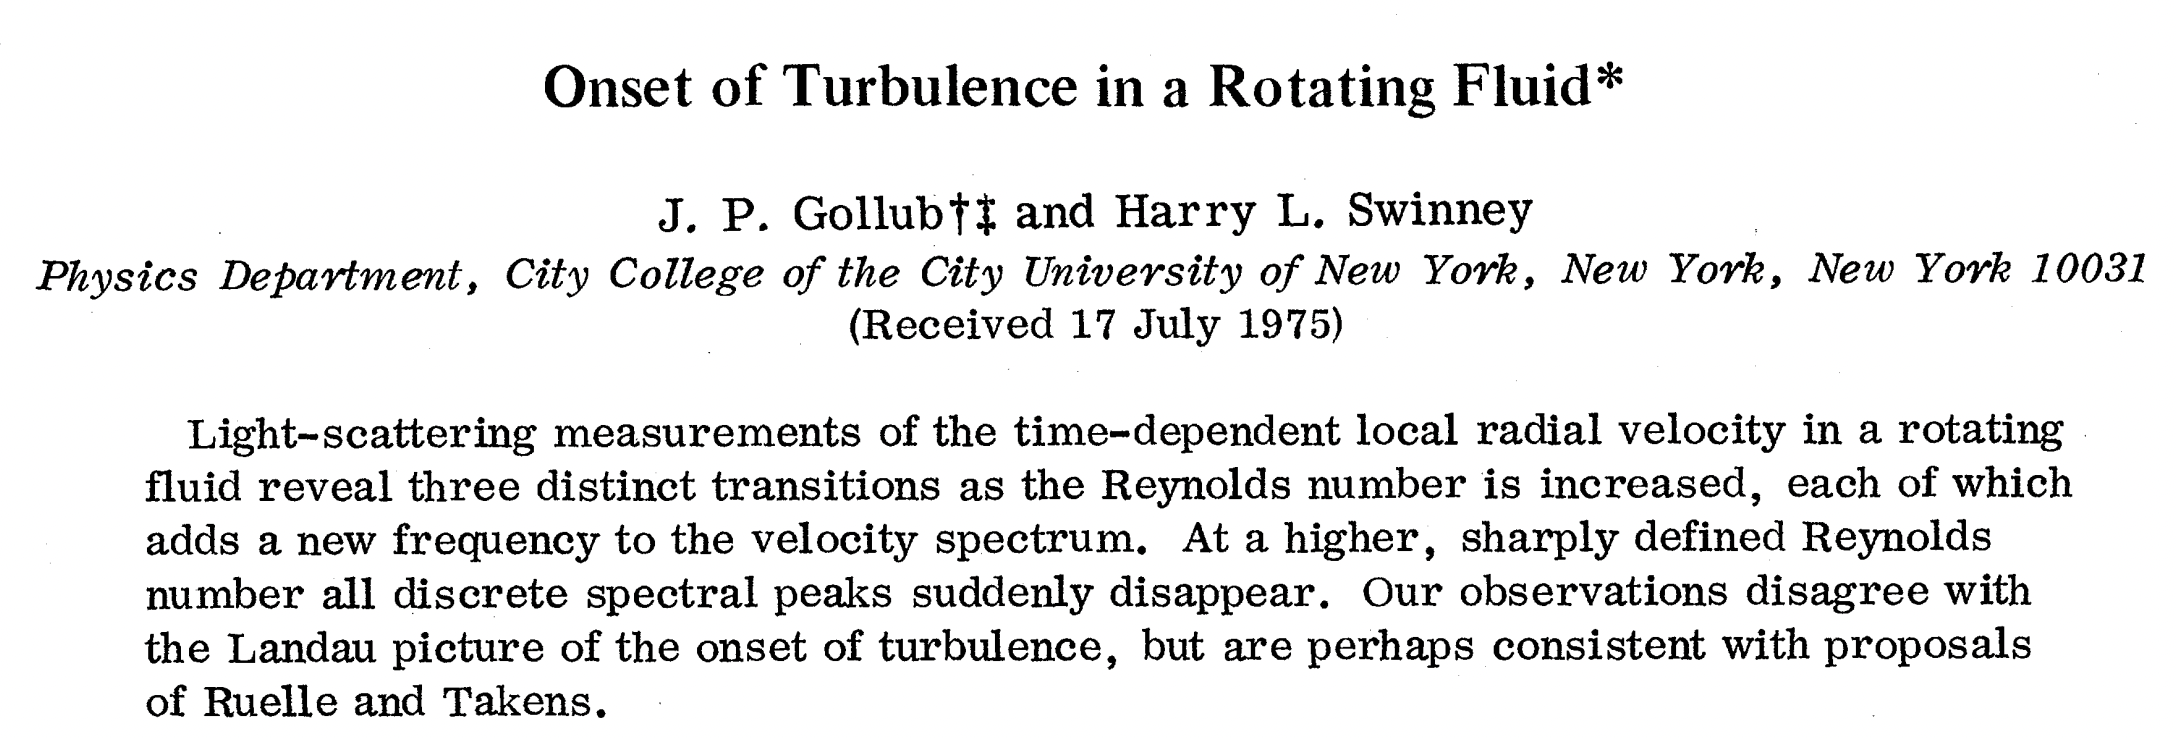

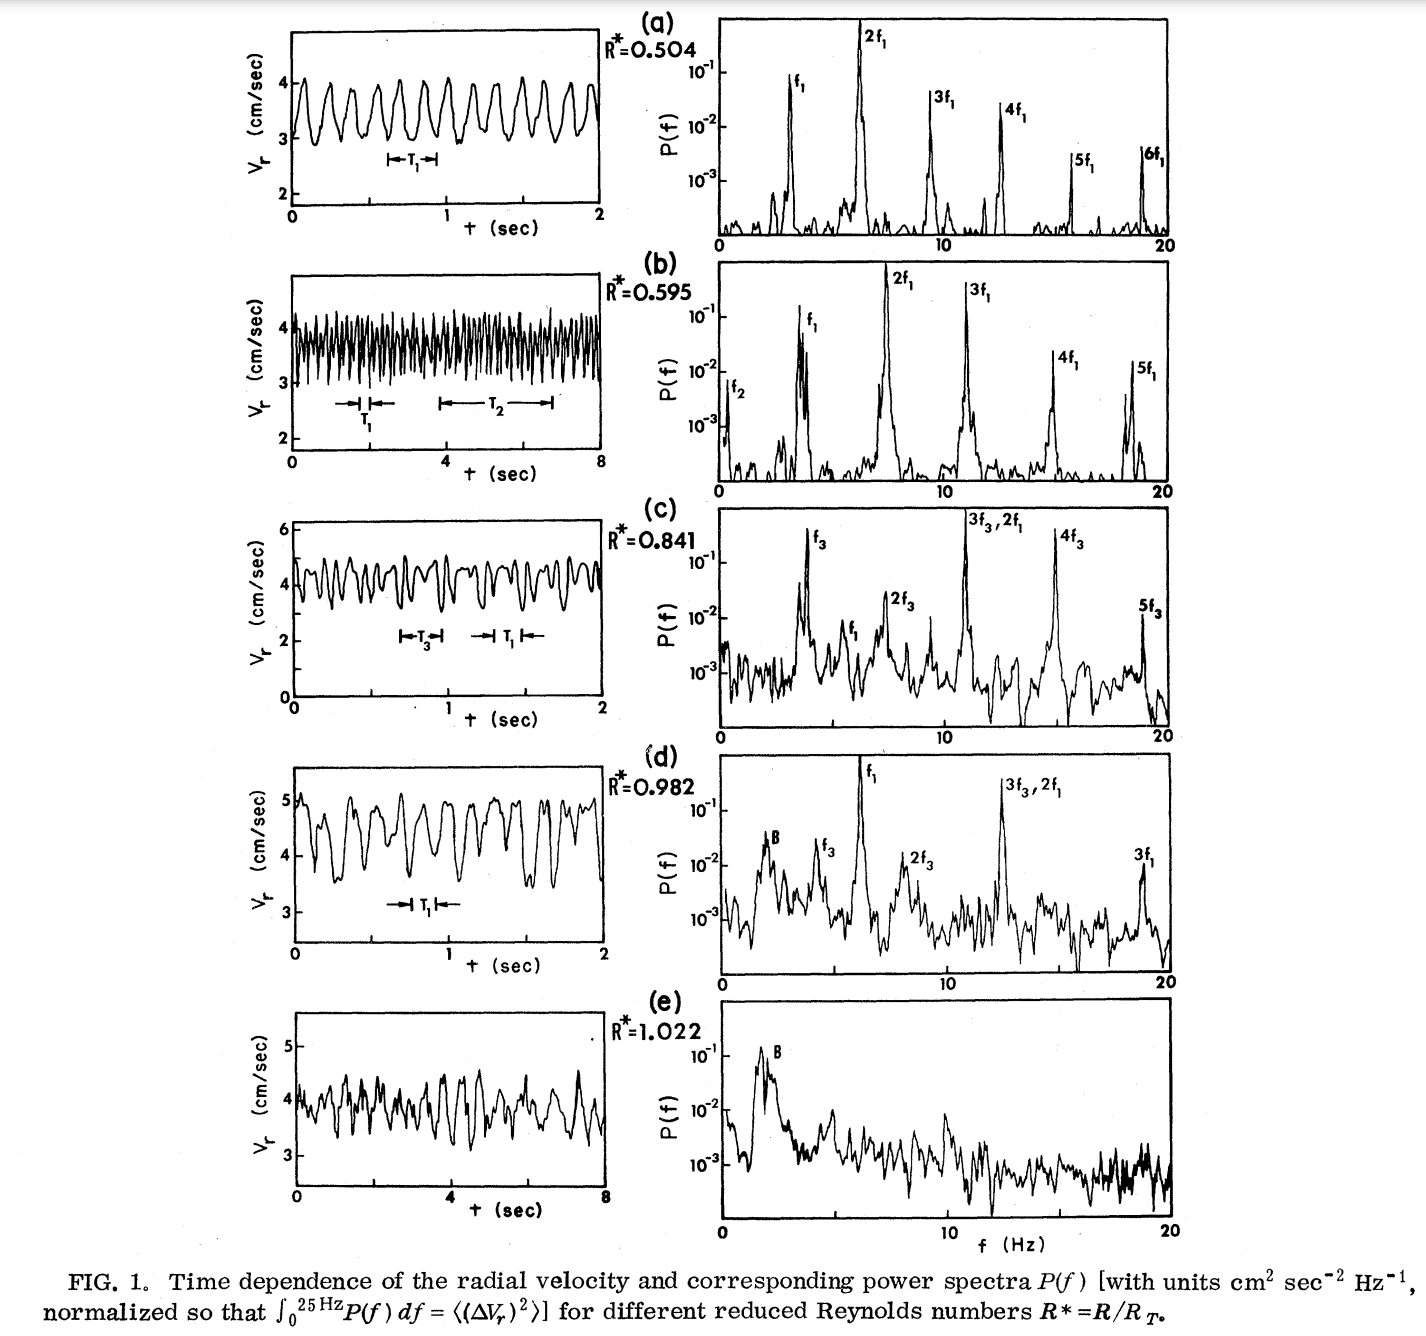

In [10]:
display(Image("../resources/swinney_gollub2.png", width=700))
display(Image("../resources/swinney_gollub1.png", width=700))